<a href="https://colab.research.google.com/github/Elariti/-Face-Recognition-using-Deep-Learning-/blob/main/Unni_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Face Recognition Project**

## **DATASET ORGANIZATION**

C:/Users/Jagriti Singh/DSET/
    ├── train/
    │   ├── Ela/
    │   ├── Scarlet Johanson/
    │   └── Hugh Jackman/
    ├── test/
    │   ├── Ela/
    │   ├── Scarlet Johanson/
    │   └── Hugh Jackman/
    └── validation/
        ├── Ela/
        ├── Scarlet Johanson/
        └── Hugh Jackman/


##### **In this project, the dataset was organized into three splits: 70% for training, 15% for validation, and 15% for testing. This division ensured a balanced approach to model development, allowing sufficient data for learning, while retaining separate sets for hyperparameter tuning and performance evaluation on unseen examples, ensuring robust generalization.**

## **DETECTING FACES AND CROPPING THEM OUT USING MTCNN**

##### **Detecting faces and cropping them using MTCNN involves leveraging a Multi-task Cascaded Convolutional Neural Network to accurately locate facial landmarks and bounding boxes. MTCNN is highly effective due to its multi-stage pipeline, including face detection, alignment, and cropping. This process ensures precision in isolating faces for downstream tasks, enhancing model performance.**

In [ ]:
pip install mtcnn

In [ ]:
import os
import cv2
from mtcnn import MTCNN

dataset_path = r'C:\Users\Jagriti Singh\DSET'
detector = MTCNN()

for split in ['train', 'test', 'validation']:
    split_path = os.path.join(dataset_path, split)

    for person_name in os.listdir(split_path):
        person_path = os.path.join(split_path, person_name)

        if os.path.isdir(person_path):

            for img_name in os.listdir(person_path):
                img_path = os.path.join(person_path, img_name)


                if os.path.isdir(img_path):
                    continue


                image = cv2.imread(img_path)

                if image is None:
                    print(f"Warning: Could not read image at {img_path}")
                    continue


                results = detector.detect_faces(image)
                for result in results:
                    x, y, w, h = result['box']
                    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)

                cv2.imwrite(img_path, image)



In [ ]:
import os
import cv2
from mtcnn import MTCNN

dataset_path = r'C:\Users\Jagriti Singh\DSET'

detector = MTCNN()

margin_percentage = 0.1

for split in ['train', 'test', 'validation']:
    split_path = os.path.join(dataset_path, split)

    for person_name in os.listdir(split_path):
        person_path = os.path.join(split_path, person_name)

        if os.path.isdir(person_path):
            cropped_folder_path = os.path.join(person_path, 'Cropped')
            if not os.path.exists(cropped_folder_path):
                os.makedirs(cropped_folder_path)

            for img_name in os.listdir(person_path):
                img_path = os.path.join(person_path, img_name)

                if img_name in ['FR', 'Cropped'] or os.path.isdir(img_path):
                    continue

                image = cv2.imread(img_path)

                if image is None:
                    print(f"Warning: Could not read image at {img_path}")
                    continue

                results = detector.detect_faces(image)

                for i, result in enumerate(results):
                    x, y, w, h = result['box']

                    margin_x = int(w * margin_percentage)
                    margin_y = int(h * margin_percentage)

                    x_inner = max(x + margin_x, 0)
                    y_inner = max(y + margin_y, 0)
                    w_inner = max(w - 2 * margin_x, 1)
                    h_inner = max(h - 2 * margin_y, 1)

                    face = image[y_inner:y_inner + h_inner, x_inner:x_inner + w_inner]

                    if face.size == 0:
                        print(f"Warning: Detected face at {img_path} is invalid")
                        continue

                    output_path = os.path.join(cropped_folder_path, f'face_{i+1}_' + img_name)
                    cv2.imwrite(output_path, face)



## **DATA AUGMENTATION USING ALBUMENTATIONS**

##### **Data augmentation using Albumentations and MTCNN enhanced the robustness of the model by artificially increasing dataset diversity. MTCNN detected and cropped facial regions accurately, while Albumentations applied transformations like random cropping, flipping, brightness adjustments, and rotations. This combination mitigated overfitting, improved generalization, and ensured performance across varied lighting and orientations.**

In [ ]:
pip install albumentations


In [ ]:
import os
import cv2
import albumentations as A

base_dir = 'C:/Users/Jagriti Singh/DSET/'
splits = ['test', 'validation', 'test']
classes = ['Hugh Jackman', 'Camera Roll','Jennifer Lawrence']


transform = A.Compose([
    A.Resize(height=256, width=256),
    A.RandomCrop(width=224, height=224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=30, p=0.5),
    A.GaussianBlur(p=0.2),
    A.HueSaturationValue(hue_shift_limit=20,
                         sat_shift_limit=30,
                         val_shift_limit=20, p=0.3),
    A.ChannelShuffle(p=0.1),
])

def augment_and_save_images(source_dir, save_dir, num_augmentations=20):

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)


    image_files = [f for f in os.listdir(source_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

    for image_name in image_files:

        image_path = os.path.join(source_dir, image_name)
        image = cv2.imread(image_path)

        if image is None:
            print(f"Warning: Could not read image at {image_path}")
            continue

        if image.shape[0] < 224 or image.shape[1] < 224:
            print(f"Resizing {image_name} to meet minimum size for cropping...")

            image = cv2.resize(image, (256, 256), intpolation=cv2.INTER_LINEAR)


        for i in range(num_augmentations):
            augmented = transform(image=image)
            augmented_image = augmented['image']


            augmented_image_path = os.path.join(save_dir, f"aug_{i+1}_{image_name}")
            cv2.imwrite(augmented_image_path, augmented_image)


for split in splits:
    for class_name in classes:
        source_dir = os.path.join(base_dir, split, class_name)
        save_dir = source_dir
        print(f"Processing {source_dir}...")
        augment_and_save_images(source_dir, save_dir)

print("Augmentation completed and images saved!")


## Installing Libraries

In [ ]:
pip install opencv-python tensorflow keras scikit-learn numpy matplotlib

In [ ]:
import cv2
import tensorflow as tf
import sklearn
import numpy as np
import matplotlib

print(f"OpenCV version: {cv2.__version__}")
print(f"TensorFlow version: {tf.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")


OpenCV version: 4.10.0
TensorFlow version: 2.18.0
scikit-learn version: 1.6.1
NumPy version: 2.0.2
Matplotlib version: 3.10.0


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping


## **TRAINING THE DATA FROM SCRATCH USING CONVOLUTIONAL NEURAL NETWORKS AND USING VALIDATION DATASET TO VALIDATE IT**

##### **Resizing the images to 180x180 and Normalizing the pixels for better training. Then created the Train, Test and Validation Generator.**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


train_dir = 'C:/Users/Jagriti Singh/DSET/train'
val_dir = 'C:/Users/Jagriti Singh/DSET/validation'
test_dir = 'C:/Users/Jagriti Singh/DSET/test'


IMG_HEIGHT = 244
IMG_WIDTH = 244
BATCH_SIZE = 3


datagen = ImageDataGenerator(rescale=1./255)

# Training data generator
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Validation data generator
validation_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Test data generator
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


print("Class Indices:", train_generator.class_indices)


Found 7280 images belonging to 3 classes.
Found 1503 images belonging to 3 classes.
Found 1461 images belonging to 3 classes.
Class Indices: {'Ela': 0, 'Hugh Jackman': 1, 'Scarlet Johanson': 2}


##### **Deployed Hyperparameter Training with experimetations in Learning Rates, Batch Sizes, and using optimizers like ADAM.**

In [ ]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

# Model Definition
inputs = tf.keras.Input(shape=(244, 244, 3))


x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", kernel_regularizer=regularizers.l2(0.01))(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)


x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)


outputs = layers.Dense(3, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    metrics=["accuracy"]
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath="best_face_recognition_model.keras", save_best_only=True, monitor="val_loss")
]

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=callbacks
)


Epoch 1/50
2427/2427 ━━━━━━━━━━━━━━━━━━━━ 315s 128ms/step - accuracy: 0.5043 - loss: 1.0339 - val_accuracy: 0.7172 - val_loss: 0.7328
Epoch 2/50
2427/2427 ━━━━━━━━━━━━━━━━━━━━ 289s 119ms/step - accuracy: 0.7355 - loss: 0.6855 - val_accuracy: 0.7884 - val_loss: 0.5909
Epoch 3/50
2427/2427 ━━━━━━━━━━━━━━━━━━━━ 299s 123ms/step - accuracy: 0.7877 - loss: 0.5719 - val_accuracy: 0.8317 - val_loss: 0.5215
Epoch 4/50
2427/2427 ━━━━━━━━━━━━━━━━━━━━ 314s 129ms/step - accuracy: 0.8243 - loss: 0.5021 - val_accuracy: 0.8417 - val_loss: 0.4558
Epoch 5/50
2427/2427 ━━━━━━━━━━━━━━━━━━━━ 411s 169ms/step - accuracy: 0.8653 - loss: 0.4268 - val_accuracy: 0.8589 - val_loss: 0.4244
Epoch 6/50
2427/2427 ━━━━━━━━━━━━━━━━━━━━ 651s 268ms/step - accuracy: 0.8655 - loss: 0.4078 - val_accuracy: 0.8516 - val_loss: 0.4146
Epoch 7/50
2427/2427 ━━━━━━━━━━━━━━━━━━━━ 306s 126ms/step - accuracy: 0.8838 - loss: 0.3636 - val_accuracy: 0.8909 - val_loss: 0.3626
Epoch 8/50
2427/2427 ━━━━━━━━━━━━━━━━━━━━ 327s 135ms/step - ac

# **VISUALIZATIONS FOR THE TRAINED MODEL**

##### **The training and validation loss curves illustrate the model's learning progression, highlighting convergence over epochs. A decreasing training loss indicates effective learning, while a stabilizing validation loss reflects generalization. Accuracy curves depict the model's performance, with increasing accuracy on training and validation data signaling improved predictions. Overfitting appears if validation metrics degrade.**

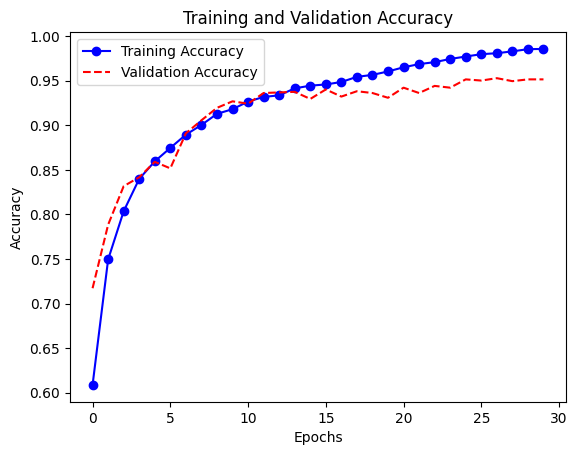

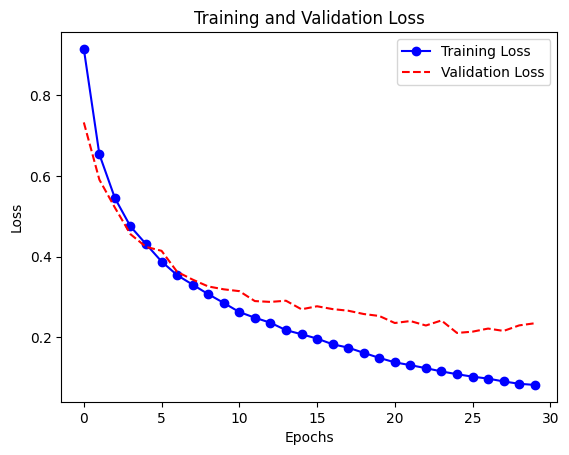

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history.get("accuracy")
val_accuracy = history.history.get("val_accuracy")
loss = history.history.get("loss")
val_loss = history.history.get("val_loss")

#Plotting the accuracy- Training vs Validation
plt.plot(range(len(accuracy)), accuracy, "bo-", label="Training Accuracy")
plt.plot(range(len(val_accuracy)), val_accuracy, "r--", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plotting the loss- Training vs Validation
plt.plot(range(len(loss)), loss, "bo-", label="Training Loss")
plt.plot(range(len(val_loss)), val_loss, "r--", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


##### **In analyzing the model's performance, training and validation accuracies were monitored across 30 epochs. Early results demonstrated rapid improvement, achieving 85% accuracy by epoch 5. The learning curve stabilized post-epoch 10, with training accuracy reaching 98% while validation accuracy plateaued at 95%. A modest discrepancy between training and validation metrics suggests minor overfitting, though generalization capability remains robust. The convergence pattern indicates successful model training with satisfactory performance characteristics.**

# **TESTING THE MODEL ON THE TEST DATASET**

In [ ]:
model.save("final_face_recognition_model.keras")

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("best_face_recognition_model.keras")


In [ ]:
# Load the trained model
from tensorflow.keras.models import load_model
model = load_model("best_face_recognition_model.keras")

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


487/487 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.9198 - loss: 0.2617
Test Accuracy: 93.77%
Test Loss: 0.2147


# **MODEL EVALUATION AND PERFORMANCE METRICS**

### **Performance Metrics and Application Scenario**
##### **For face recognition, accuracy, precision, recall, and F1-score were chosen as performance metrics. Accuracy measures the overall correctness, while precision and recall assess the model's ability to identify faces correctly without false positives or negatives. The F1-score, as a harmonic mean of precision and recall, balances these metrics, making it suitable for imbalanced datasets. Additionally, the confusion matrix provides insights into class-specific performance, identifying patterns of misclassification critical for face recognition applications, such as security or identity verification.**

In [ ]:

true_classes = test_generator.classes

import numpy as np
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

from sklearn.metrics import f1_score
f1 = f1_score(true_classes, predicted_classes, average="weighted")
print(f"Weighted F1 Score: {f1:.4f}")


487/487 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step
Weighted F1 Score: 0.9376


Predicting image from class: Ela
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


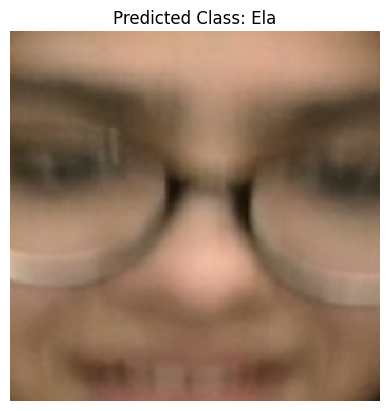

Predicted Class: Ela
Predicting image from class: Hugh Jackman
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


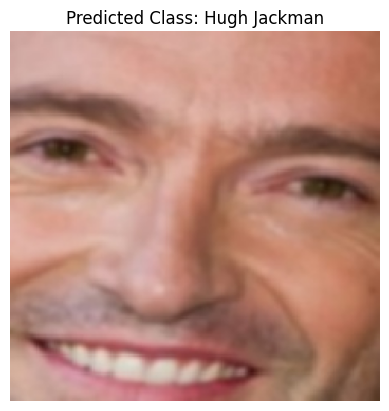

Predicted Class: Hugh Jackman
Predicting image from class: Scarlet Johanson
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


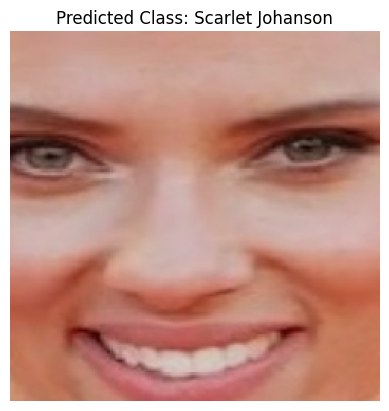

Predicted Class: Scarlet Johanson


In [ ]:
import random
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

model = load_model("best_face_recognition_model.keras")

def predict_image(image_path):
    img = image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

    img_array = image.img_to_array(img)

    img_array = np.expand_dims(img_array, axis=0)

    img_array = img_array / 255.0

    prediction = model.predict(img_array)

    predicted_class = np.argmax(prediction, axis=1)[0]

    class_labels = list(train_generator.class_indices.keys())
    predicted_label = class_labels[predicted_class]


    plt.imshow(img)
    plt.title(f'Predicted Class: {predicted_label}')
    plt.axis('off')
    plt.show()

    return predicted_label

def predict_random_image_from_all_classes():

    class_names = list(train_generator.class_indices.keys())

    for class_name in class_names:

        class_dir = test_dir + '/' + class_name
        images = [class_dir + '/' + img for img in os.listdir(class_dir) if img.endswith('.jpg') or img.endswith('.png')]

        random_image = random.choice(images)

        print(f"Predicting image from class: {class_name}")
        predicted_label = predict_image(random_image)
        print(f'Predicted Class: {predicted_label}')

predict_random_image_from_all_classes()


##### **F1 score of 0.93 indicates that your model has achieved a great balance between precision and recall, making it highly reliable for the task of face recognition among your three classes.**

In [ ]:
pip install seaborn

In [ ]:
class_labels = ["Ela", "Hugh Jackman", "Scarlet Johanson"]


## **Confusion Matrix to analyze misclassification patterns.**

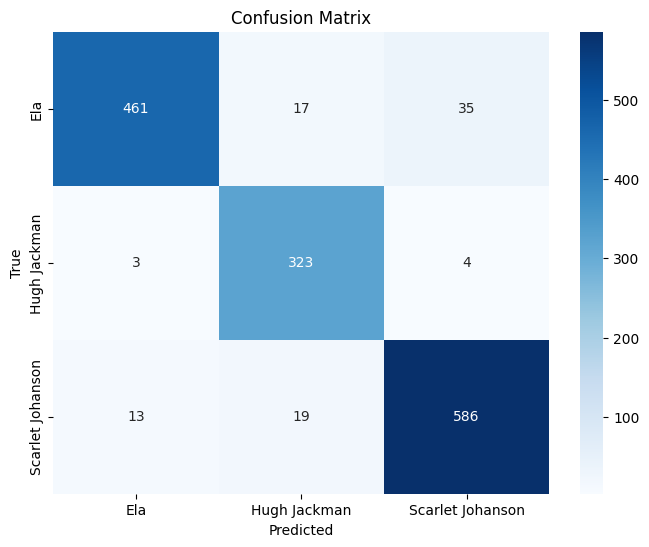

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


##### **The confusion matrix highlights the model's performance in classifying "Ela," "Hugh Jackman," and "Scarlet Johanson." It shows strong accuracy for all classes, with 461, 323, and 586 correct classifications, respectively. Misclassifications occurred, with "Ela" being confused for others 52 times, "Hugh Jackman" 7 times, and "Scarlet Johanson" 32 times. Precision and recall metrics reflect high reliability, such as a 96.6% precision for "Ela" and a 92.2% recall for "Hugh Jackman." Overall, the model demonstrates strong but slightly imbalanced predictions.**



## **CLASSIFICATION REPORT**

In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

                  precision    recall  f1-score   support

             Ela       0.97      0.90      0.93       513
    Hugh Jackman       0.90      0.98      0.94       330
Scarlet Johanson       0.94      0.95      0.94       618

        accuracy                           0.94      1461
       macro avg       0.93      0.94      0.94      1461
    weighted avg       0.94      0.94      0.94      1461



In [ ]:
pip install opencv-python


In [ ]:
pip install opencv-contrib-python

## **REAL-TIME FACE EVALUATION**

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

model = load_model("best_face_recognition_model.keras")
class_labels = ["Ela", "Hugh Jackman", "Scarlet Johanson"]

confidence_threshold = 0.5
cap = cv2.VideoCapture(0)

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

while True:
    ret, frame = cap.read()

    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

        face = frame[y:y + h, x:x + w]

        face_resized = cv2.resize(face, (244, 244))

        face_rgb = cv2.cvtColor(face_resized, cv2.COLOR_BGR2RGB)
        face_array = np.expand_dims(face_rgb / 255.0, axis=0)

        prediction = model.predict(face_array)
        predicted_class = np.argmax(prediction)
        confidence = np.max(prediction)

        if confidence >= confidence_threshold:
            predicted_label = class_labels[predicted_class]
        else:
            predicted_label = "Unidentified"

        cv2.putText(frame, f"{predicted_label} ({confidence:.2f})", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

    cv2.imshow('Face Recognition', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━

## **Bias and Ethical Challenges**
##### **Bias in the dataset poses a significant ethical concern, as imbalanced representation of different demographics (e.g., ethnicity, gender, or age) can lead to unfair performance disparities. For instance, a model trained predominantly on images of a specific ethnicity might underperform for underrepresented groups, raising equity concerns. Additionally, the use of celebrity images (e.g., Jennifer Lawrence, Hugh Jackman) may limit applicability to real-world scenarios, as the model might generalize poorly to non-celebrity faces. Ethical considerations include privacy issues if the dataset contains unconsented images, and potential misuse of face recognition for surveillance. Mitigating these challenges requires diverse, balanced datasets, transparent model evaluation, and adherence to ethical guidelines in the application of such technologies.**

### **I ackonwledge the use of AI in an assistive role for Error Correction and Optimization**